In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import cv2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

### Pre-processing

In [2]:
files_dir = "assignment_dataset/train/image"
labels_dir = "assignment_dataset/train/label"

processed_image_dir = "preprocessed/image"
processed_label_dir = "preprocessed/label"

files = os.listdir(files_dir)
labels = os.listdir(labels_dir)

In [3]:
def get_img_n_label(cvt_grayscale = True):

    X = []
    y = []

    img_files = []
    label_files = []
    
    processed_image_dir = "preprocessed/image"
    processed_label_dir = "preprocessed/label"

    for file in files:
        img = cv2.imread(os.path.join(files_dir,file))
        img = cv2.resize(img, (128,128))
        if cvt_grayscale == True:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(processed_image_dir, file), img)

        X.append(img)

        label = file.split(".")[0]+".png"
        label_img = cv2.imread(os.path.join(labels_dir, label))
        label_img = cv2.resize(label_img, (128,128))
        if cvt_grayscale == True:
            label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(processed_label_dir, label), label_img)

        y.append(label_img)

        img_files.append(file)
        label_files.append(label)

    X = np.array(X)
    y = np.array(y)

    #Normalize
    X = X/255.0
    y = y/255.0

    print(img_files)
    print(label_files)

    return X,y

In [4]:
X_gray, y_gray = get_img_n_label()
print(X_gray.shape, y_gray.shape)

['8.jpg', '28.jpg', '29.jpg', '15.jpg', '17.jpg', '16.jpg', '13.jpg', '39.jpg', '11.jpg', '38.jpg', '21.jpg', '35.jpg', '20.jpg', '22.jpg', '23.jpg', '27.jpg', '26.jpg', '32.jpg', '24.jpg', '30.jpg', '31.jpg', '19.jpg', '5.jpg', '43.jpg', '7.jpg', '41.jpg', '44.jpg', '45.jpg', '47.jpg', '46.jpg']
['8.png', '28.png', '29.png', '15.png', '17.png', '16.png', '13.png', '39.png', '11.png', '38.png', '21.png', '35.png', '20.png', '22.png', '23.png', '27.png', '26.png', '32.png', '24.png', '30.png', '31.png', '19.png', '5.png', '43.png', '7.png', '41.png', '44.png', '45.png', '47.png', '46.png']
(30, 128, 128) (30, 128, 128)


#### Display preocessed images

In [166]:
def display_processed_images(is_grayscale=True):
    for file,label in zip(files,labels):
        print(file, label)
        
        if is_grayscale == True:
            img = cv2.imread(os.path.join(processed_image_dir,file), cv2.IMREAD_GRAYSCALE )
            label = cv2.imread(os.path.join(processed_label_dir,label), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(processed_image_dir,file) )
            label = cv2.imread(os.path.join(processed_label_dir,label))
        
        fig, (ax1, ax2, ax3) = plt.subplots(1,3)

        overlay_image = cv2.addWeighted(img,1,label,.1,0)
        ax1.set_title("Image")
        ax1.imshow(img)
        ax2.set_title("Label")
        ax2.imshow(label)
        ax3.set_title("Superimposed")
        ax3.imshow(overlay_image)

        plt.show()

8.jpg 8.png


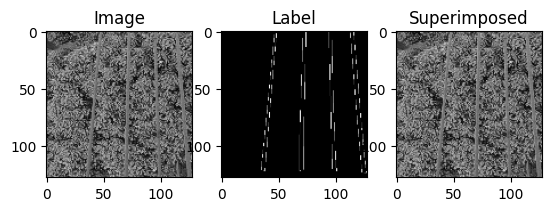

28.jpg 28.png


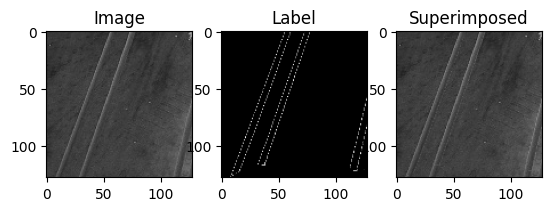

29.jpg 29.png


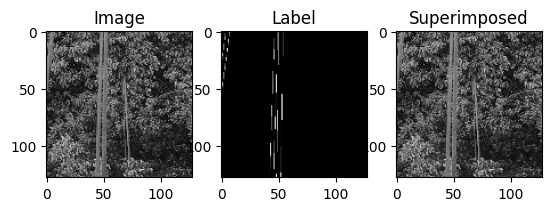

15.jpg 15.png


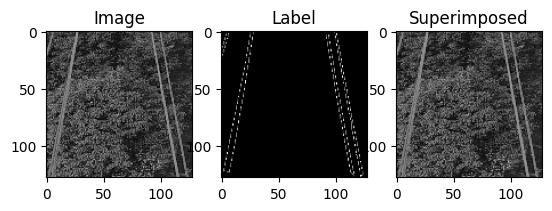

17.jpg 17.png


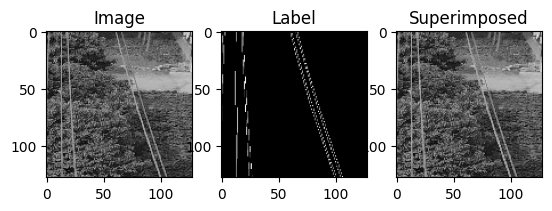

16.jpg 16.png


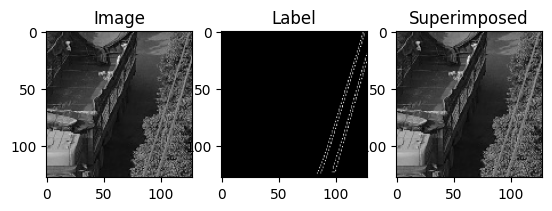

13.jpg 13.png


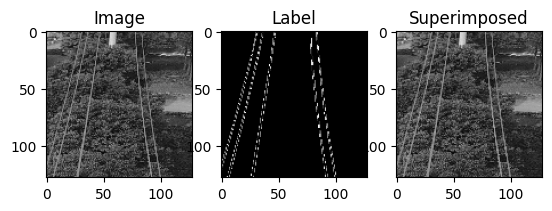

39.jpg 39.png


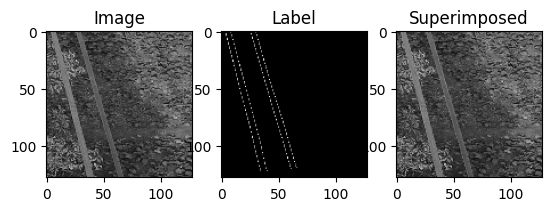

11.jpg 11.png


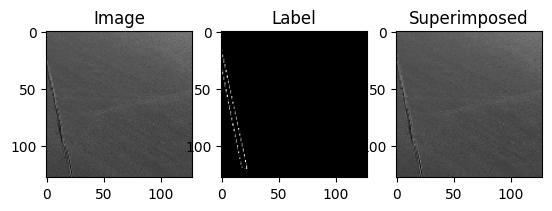

38.jpg 38.png


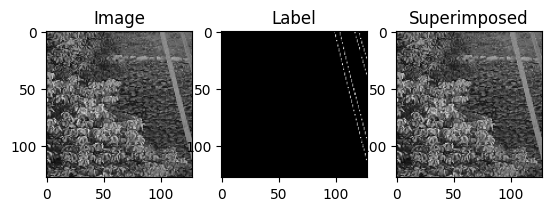

21.jpg 35.png


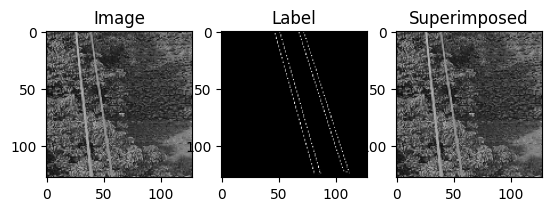

35.jpg 21.png


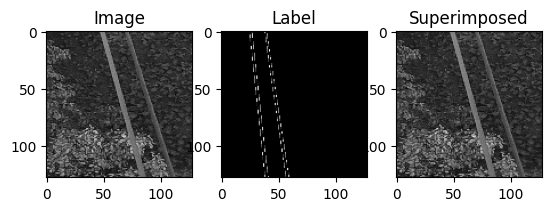

20.jpg 20.png


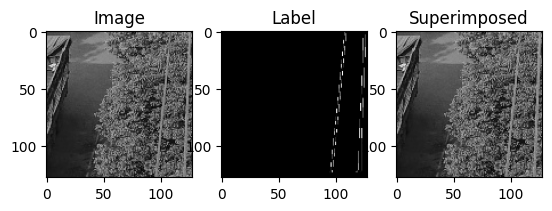

22.jpg 22.png


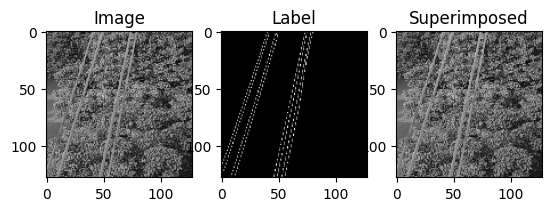

23.jpg 23.png


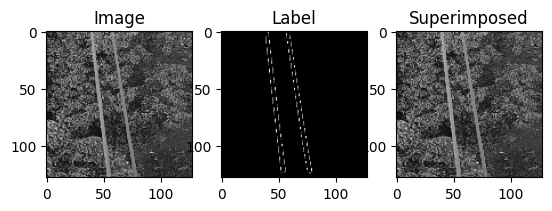

27.jpg 27.png


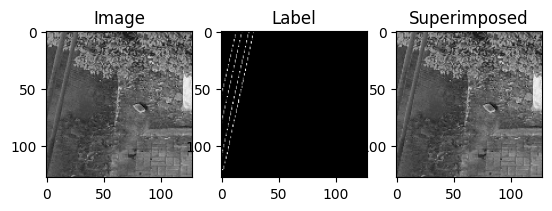

26.jpg 32.png


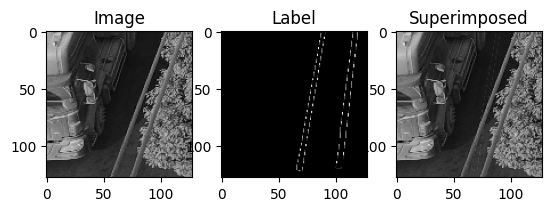

32.jpg 26.png


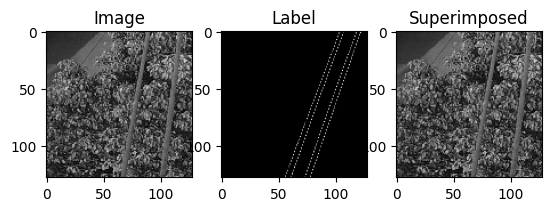

24.jpg 30.png


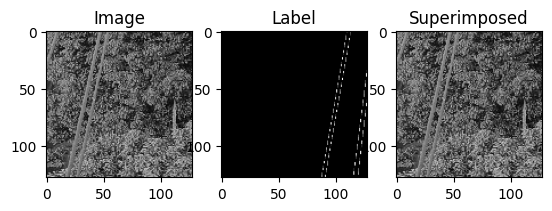

30.jpg 24.png


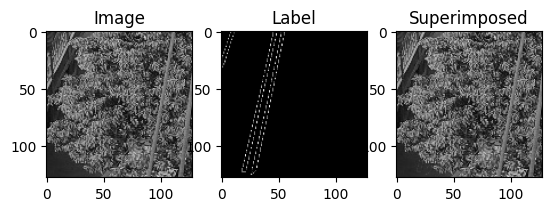

31.jpg 31.png


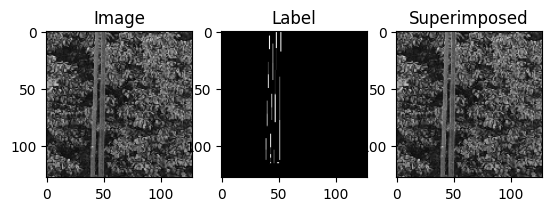

19.jpg 19.png


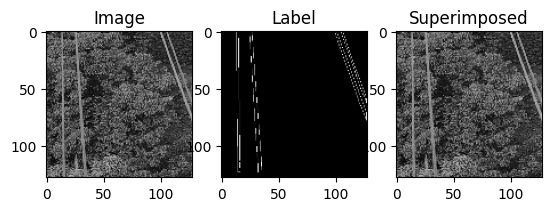

5.jpg 43.png


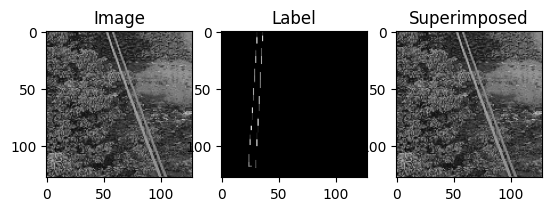

43.jpg 5.png


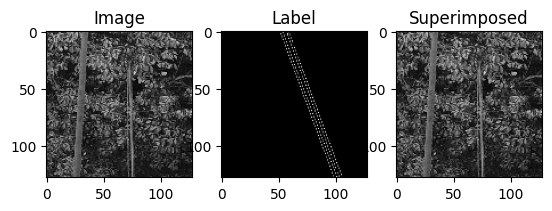

7.jpg 41.png


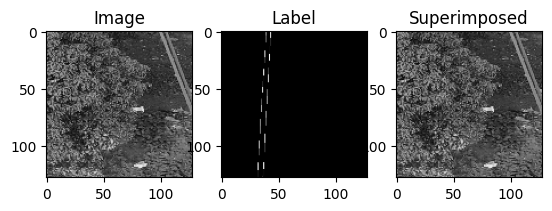

41.jpg 7.png


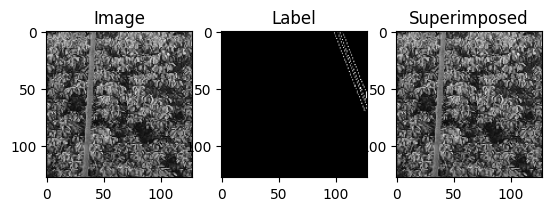

44.jpg 44.png


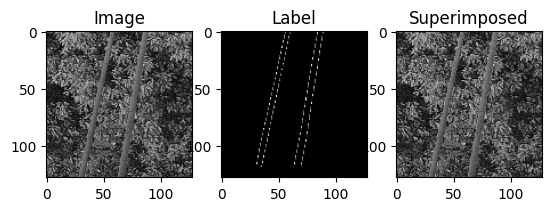

45.jpg 45.png


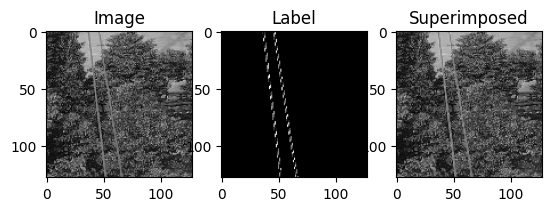

47.jpg 47.png


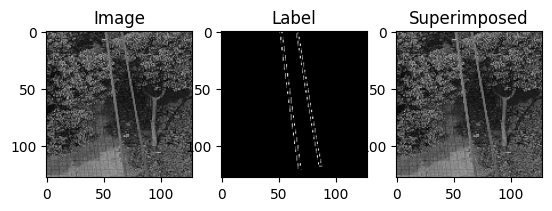

46.jpg 46.png


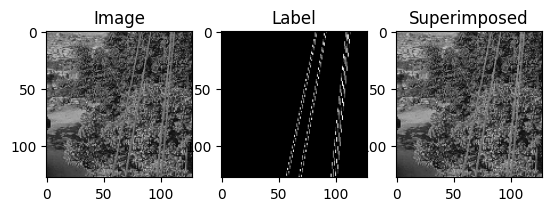

In [167]:
display_processed_images(is_grayscale=False)

## Modeling

#### Functions

In [7]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.05)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.05)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

def double_conv_block_gray(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal", data_format="channels_last")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal", data_format="channels_last")(x)

   return x

def build_unet_model(is_out_gray=True, optimizer=tf.keras.optimizers.legacy.Adam(), loss="binary_crossentropy", metrics=['accuracy']):
    # inputs
   if is_out_gray == True:
      inputs = layers.Input(shape=(128,128,1))
   else:
      inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   if is_out_gray == True:
      f1 = double_conv_block_gray(inputs, 64)
      p1 = layers.MaxPool2D(2)(f1)
      p1 = layers.Dropout(0.3)(p1)
      
   else:
      f1, p1 = downsample_block(inputs, 64)

   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   if is_out_gray == True:
      outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
   else :
      outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   print("--------------------------------------Model Params-----------------------------------------")
   print("Optimizer=", optimizer)
   print("loss=", loss)
   print("metrics=", metrics)
   unet_model.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=metrics)

   return unet_model

In [8]:
def train_unet_model(X, y, validation_data, is_out_gray=True, optimizer=tf.keras.optimizers.legacy.Adam(), loss="binary_crossentropy", metrics=['accuracy'],
                            epochs=10, batch_size=10, callbacks=[]):
    
    model = build_unet_model(is_out_gray=is_out_gray, optimizer=optimizer, loss=loss, metrics=metrics)

    print("-----------------------------------------Model Training---------------------------------------------")
    model_history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_data=validation_data,
                                                    callbacks=callbacks
    )

    print("-----------------------------------------Model History---------------------------------------------")
    #Plot the first of the metrics
    met1 = str(metrics[0]).lower()
    val_met1 = "val_" + met1
    
    plt.figure(figsize=(10,3))

    plt.subplot(1,3,1)
    sns.lineplot(x=range(0,epochs), y=model_history.history[met1]).set(title= met1 + " Vs Epochs")

    plt.subplot(1,3,2)
    sns.lineplot(x=range(0,epochs), y=model_history.history[val_met1]).set(title= val_met1 + " Vs Epochs")

    plt.subplot(1,3,3)
    sns.lineplot(x=range(0,epochs), y=model_history.history['loss']).set(title="loss Vs Epochs")

    plt.show()

    print("----------------------------------------Model Test Scores--------------------------------------------")
    print(model.evaluate(X_test, y_test))
    
    print("---------------------------------Model Predictions : Test dataset ---------------------------------------")
    y_pred = model.predict(X_test)

    y_pred_t_4 = (y_pred > .4).astype(np.uint8)
    y_pred_t_5 = (y_pred > .5).astype(np.uint8)
    y_pred_t_7 = (y_pred > .7).astype(np.uint8)

    for x , y , pred , pred_t_4 , pred_t_5, pred_t_7 in zip(X_test, y_test, y_pred, y_pred_t_4, y_pred_t_5, y_pred_t_7):

        plt.figure(figsize=(30,7))

        _ , (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize=(10,5))
        ax1.set_title("Image")
        ax1.imshow(x, cmap="gray")
        
        ax2.set_title("True")
        ax2.imshow(y, cmap="gray")
        
        ax3.set_title("Predict")
        ax3.imshow(pred, cmap="gray")
        
        ax4.set_title("Pred Binary 0.4")
        ax4.imshow(pred_t_4, cmap="gray")

        ax5.set_title("Pred Binary 0.5")
        ax5.imshow(pred_t_5, cmap="gray")

        ax6.set_title("Pred Binary 0.7")
        ax6.imshow(pred_t_7, cmap="gray")

        plt.show()

    return (model, model_history)


In [16]:
def predict_n_plot(model, X, y):
    
    print(model.evaluate(X, y))

    y_pred = model.predict(X)
    y_pred_t_4 = (y_pred > .4).astype(np.uint8)
    y_pred_t_5 = (y_pred > .5).astype(np.uint8)
    y_pred_t_7 = (y_pred > .7).astype(np.uint8)

    for x , y , pred , pred_t_4 , pred_t_5, pred_t_7 in zip(X, y, y_pred, y_pred_t_4, y_pred_t_5, y_pred_t_7):

        plt.figure(figsize=(30,7))

        _ , (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize=(10,5))
        ax1.set_title("Image")
        ax1.imshow(x, cmap="gray")
        
        ax2.set_title("True")
        ax2.imshow(y, cmap="gray")
        
        ax3.set_title("Predict")
        ax3.imshow(pred, cmap="gray")
        
        ax4.set_title("Pred Binary 0.4")
        ax4.imshow(pred_t_4, cmap="gray")

        ax5.set_title("Pred Binary 0.5")
        ax5.imshow(pred_t_5, cmap="gray")

        ax6.set_title("Pred Binary 0.7")
        ax6.imshow(pred_t_7, cmap="gray")
    

#### Data Split

In [9]:
def preprocess_images(X,y, percentile = .9):
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
    print("New Shape :",X.shape, y.shape)

    percentile_split = int(X.shape[0] * percentile)
    print("Split @ : ", percentile_split)

    X_train = X[0:percentile_split]
    X_test = X[percentile_split:]
    y_train = y[0:percentile_split]
    y_test = y[percentile_split:]

    print("Shapes after split : ", X_train.shape, y_train.shape,X_test.shape, y_test.shape )
    return (X_train, X_test, y_train, y_test )

In [10]:
X_train, X_test, y_train, y_test = preprocess_images(X_gray, y_gray)

New Shape : (30, 128, 128, 1) (30, 128, 128, 1)
Split @ :  27
Shapes after split :  (27, 128, 128, 1) (27, 128, 128, 1) (3, 128, 128, 1) (3, 128, 128, 1)


### Experiments

#### Ablation

--------------------------------------Model Params-----------------------------------------
Optimizer= <keras.optimizers.legacy.adam.Adam object at 0x29dba5400>
loss= binary_crossentropy
metrics= ['accuracy']
-----------------------------------------Model Training---------------------------------------------


2023-05-11 11:22:06.241801: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - ETA: 0s - loss: 35.3936 - accuracy: 0.7116
Epoch 1: val_loss improved from inf to 0.11620, saving model to model/ablation/best_model.h5
3/3 [==============================] - 9s 2s/step - loss: 35.3936 - accuracy: 0.7116 - val_loss: 0.1162 - val_accuracy: 0.9696 - lr: 0.0010
-----------------------------------------Model History---------------------------------------------


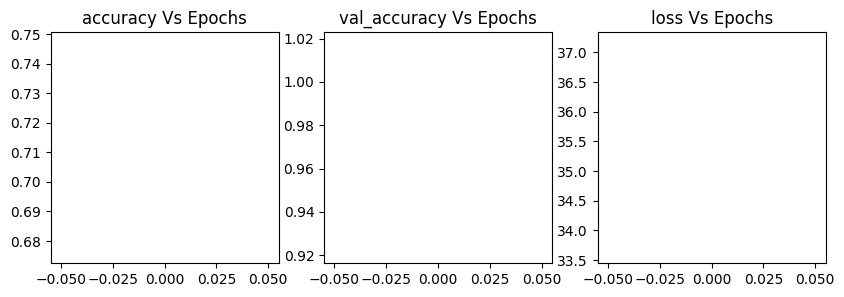

----------------------------------------Model Test Scores--------------------------------------------
1/1 [==============================] - 0s 242ms/step - loss: 0.1162 - accuracy: 0.9696
[0.11620470136404037, 0.9695841670036316]
---------------------------------Model Predictions : Test dataset ---------------------------------------
1/1 [==============================] - 0s 394ms/step


<Figure size 3000x700 with 0 Axes>

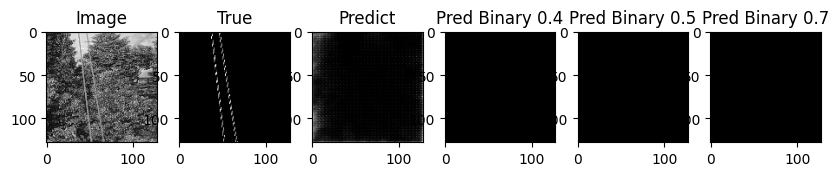

<Figure size 3000x700 with 0 Axes>

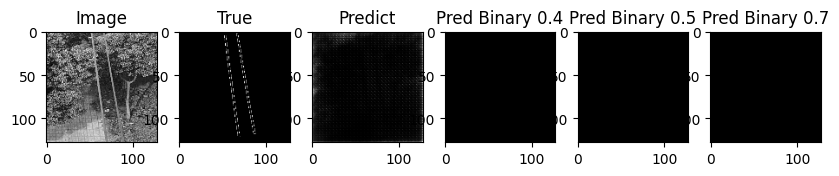

<Figure size 3000x700 with 0 Axes>

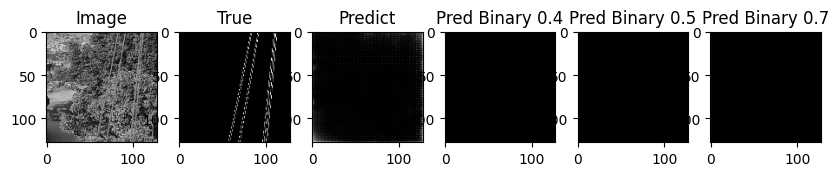

(<keras.engine.functional.Functional at 0x2be014e50>,
 <keras.callbacks.History at 0x29db98d00>)

In [11]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/ablation/best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

train_unet_model(X_train, y_train, (X_test, y_test), epochs=1, callbacks=callbacks)

#### Adam optimizer with learning rate 1e-4

--------------------------------------Model Params-----------------------------------------
Optimizer= <keras.optimizers.legacy.adam.Adam object at 0x2c9719f10>
loss= binary_crossentropy
metrics= ['accuracy']
-----------------------------------------Model Training---------------------------------------------
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.3258
Epoch 1: val_loss improved from inf to 0.49568, saving model to model/adam_optimizer_with_lr/best_model.h5
3/3 [==============================] - 9s 2s/step - loss: 0.7948 - accuracy: 0.3258 - val_loss: 0.4957 - val_accuracy: 0.9329 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.9523
Epoch 2: val_loss improved from 0.49568 to 0.13944, saving model to model/adam_optimizer_with_lr/best_model.h5
3/3 [==============================] - 7s 2s/step - loss: 0.3157 - accuracy: 0.9523 - val_loss: 0.1394 - val_accuracy: 0.9694 - lr: 1.0000e-04


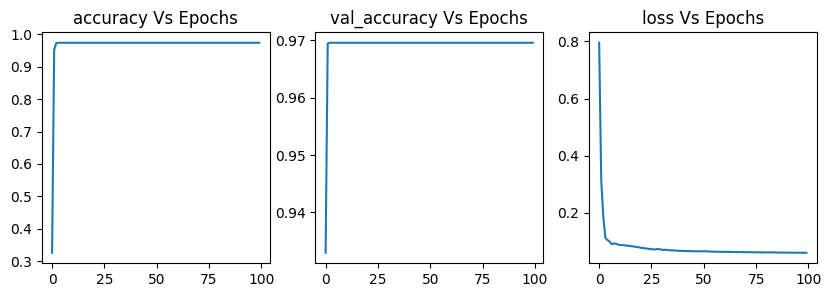

----------------------------------------Model Test Scores--------------------------------------------
1/1 [==============================] - 0s 217ms/step - loss: 0.1037 - accuracy: 0.9696
[0.10365233570337296, 0.9695841670036316]
---------------------------------Model Predictions : Test dataset ---------------------------------------
1/1 [==============================] - 0s 340ms/step


<Figure size 3000x700 with 0 Axes>

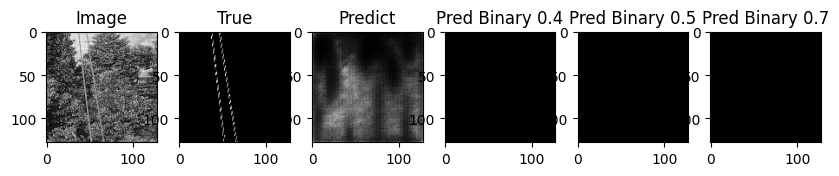

<Figure size 3000x700 with 0 Axes>

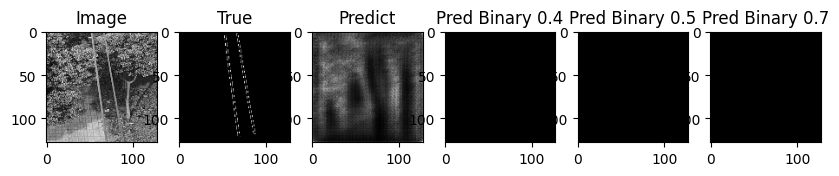

<Figure size 3000x700 with 0 Axes>

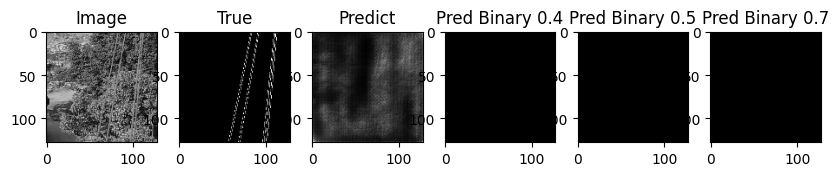

(<keras.engine.functional.Functional at 0x2c9aa1c70>,
 <keras.callbacks.History at 0x2c99a33d0>)

In [12]:
epochs = 100
callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.75, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/adam_optimizer_with_lr/best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

train_unet_model(X_train, y_train, (X_test, y_test), epochs=epochs, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), callbacks=callbacks)

#### Optimizer SGD

--------------------------------------Model Params-----------------------------------------
Optimizer= <keras.optimizers.legacy.gradient_descent.SGD object at 0x2dd76e730>
loss= binary_crossentropy
metrics= ['accuracy']
-----------------------------------------Model Training---------------------------------------------
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.8053
Epoch 1: val_loss improved from inf to 0.26958, saving model to model/sgd_optimizer/best_model.h5
3/3 [==============================] - 8s 2s/step - loss: 0.5214 - accuracy: 0.8053 - val_loss: 0.2696 - val_accuracy: 0.9696 - lr: 0.0100
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9739
Epoch 2: val_loss improved from 0.26958 to 0.16817, saving model to model/sgd_optimizer/best_model.h5
3/3 [==============================] - 7s 2s/step - loss: 0.2322 - accuracy: 0.9739 - val_loss: 0.1682 - val_accuracy: 0.9696 - lr: 0.0100
Epoch 3/100
3/3

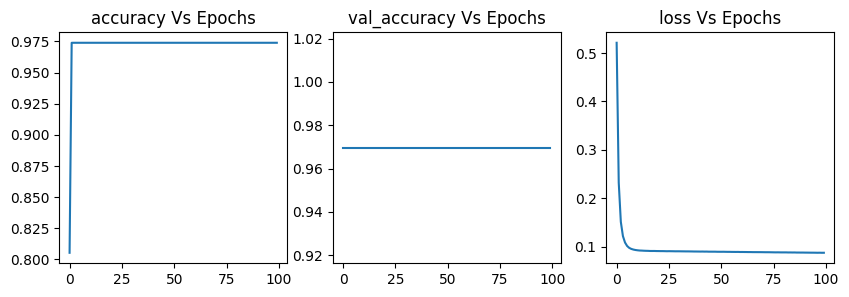

----------------------------------------Model Test Scores--------------------------------------------
1/1 [==============================] - 0s 218ms/step - loss: 0.0983 - accuracy: 0.9696
[0.09825383871793747, 0.9695841670036316]
---------------------------------Model Predictions : Test dataset ---------------------------------------
1/1 [==============================] - 0s 319ms/step


<Figure size 3000x700 with 0 Axes>

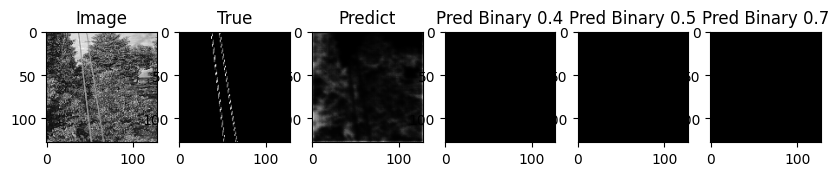

<Figure size 3000x700 with 0 Axes>

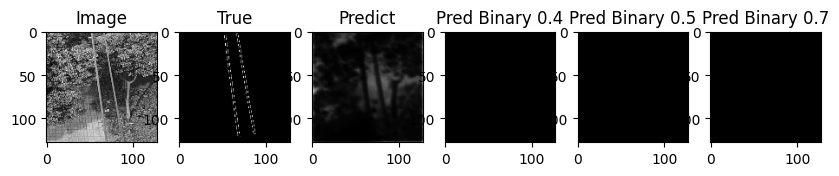

<Figure size 3000x700 with 0 Axes>

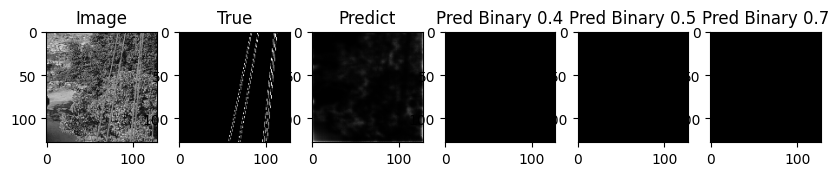

(<keras.engine.functional.Functional at 0x2dd933760>,
 <keras.callbacks.History at 0x2dd89a7c0>)

In [13]:
epochs = 100
callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.75, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/sgd_optimizer/best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

train_unet_model(X_train, y_train, (X_test, y_test), epochs=epochs, optimizer=tf.keras.optimizers.legacy.SGD(), callbacks=callbacks)

#### AUC Metric - 100 epochs

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.5703 - auc: 0.4868
Epoch 1: val_loss improved from inf to 0.21676, saving model to model/100epochs/best_model.h5
3/3 [==============================] - 9s 3s/step - loss: 0.5703 - auc: 0.4868 - val_loss: 0.2168 - val_auc: 0.3273 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.1446 - auc: 0.3782
Epoch 2: val_loss improved from 0.21676 to 0.11821, saving model to model/100epochs/best_model.h5
3/3 [==============================] - 8s 2s/step - loss: 0.1446 - auc: 0.3782 - val_loss: 0.1182 - val_auc: 0.4298 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.1211 - auc: 0.4575
Epoch 3: val_loss did not improve from 0.11821
3/3 [==============================] - 7s 2s/step - loss: 0.1211 - auc: 0.4575 - val_loss: 0.1235 - val_auc: 0.4222 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.1029 - auc: 0.4010
Epoch 4: val_loss impr

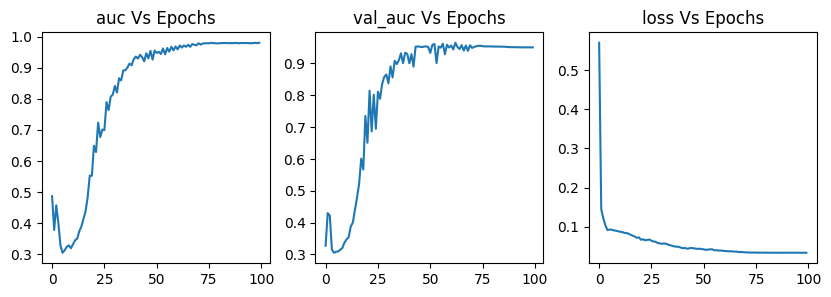

1/1 [==============================] - 0s 256ms/step - loss: 0.0439 - auc: 0.9506
[0.043909817934036255, 0.9506264925003052]
1/1 [==============================] - 0s 340ms/step


<Figure size 3000x700 with 0 Axes>

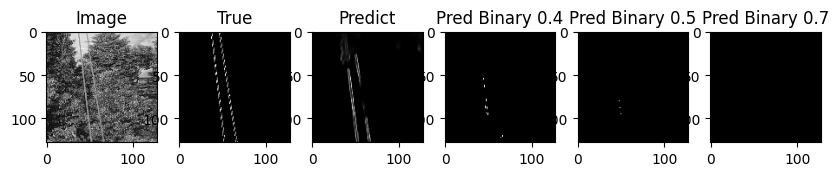

<Figure size 3000x700 with 0 Axes>

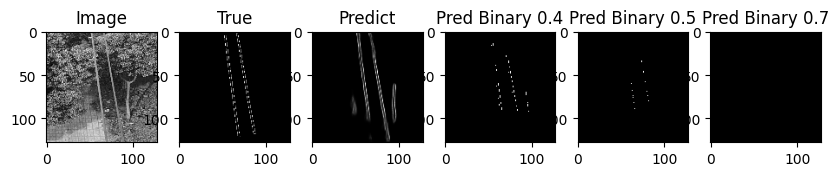

<Figure size 3000x700 with 0 Axes>

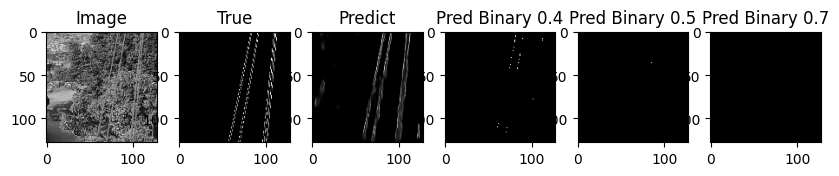

In [287]:
epochs = 100

callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/auc_metric_100/best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

train_unet_model(X_train, y_train, (X_test, y_test), epochs=epochs, metrics=['AUC'], callbacks=callbacks)

##### Train dataset

1/1 [==============================] - 3s 3s/step - loss: 0.0332 - accuracy: 0.9739
[0.03320510685443878, 0.9739063382148743]
1/1 [==============================] - 2s 2s/step


/var/folders/hm/r5pwp4rs5zd7v5745srhxk7w0000gn/T/ipykernel_4779/3278747216.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(30,7))


<Figure size 3000x700 with 0 Axes>

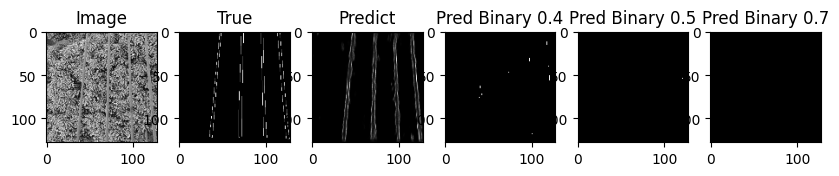

<Figure size 3000x700 with 0 Axes>

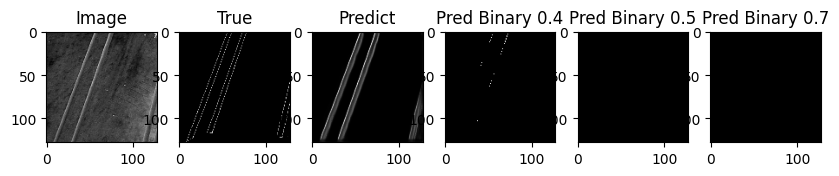

<Figure size 3000x700 with 0 Axes>

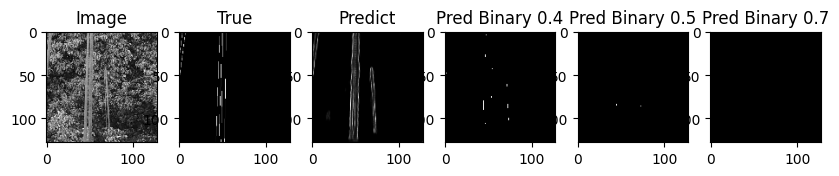

<Figure size 3000x700 with 0 Axes>

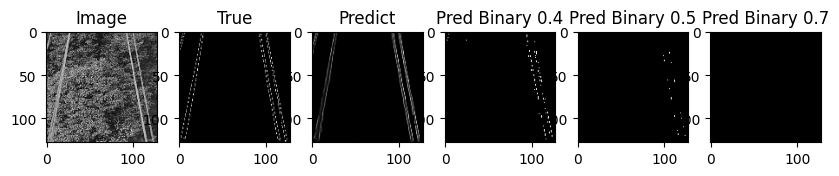

<Figure size 3000x700 with 0 Axes>

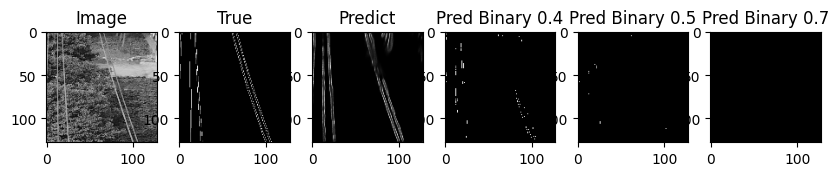

<Figure size 3000x700 with 0 Axes>

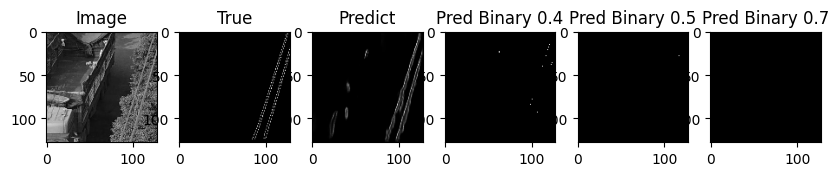

<Figure size 3000x700 with 0 Axes>

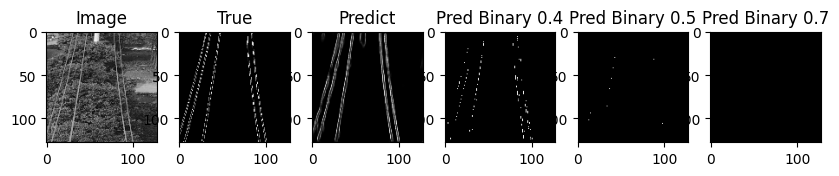

<Figure size 3000x700 with 0 Axes>

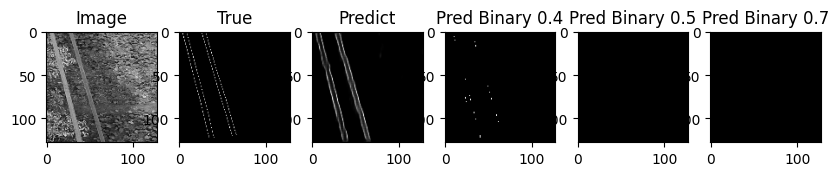

<Figure size 3000x700 with 0 Axes>

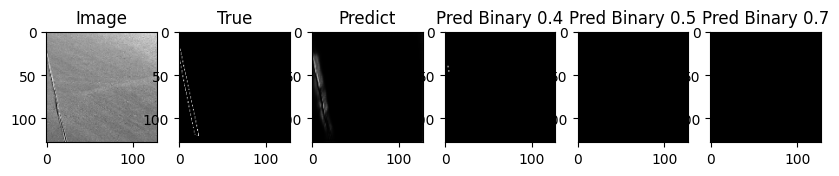

<Figure size 3000x700 with 0 Axes>

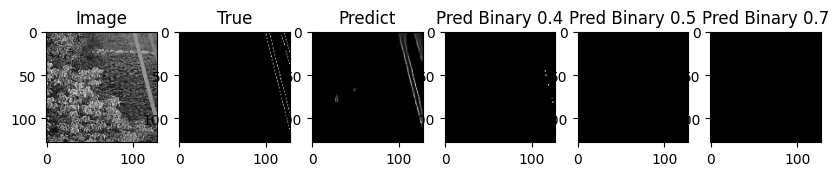

<Figure size 3000x700 with 0 Axes>

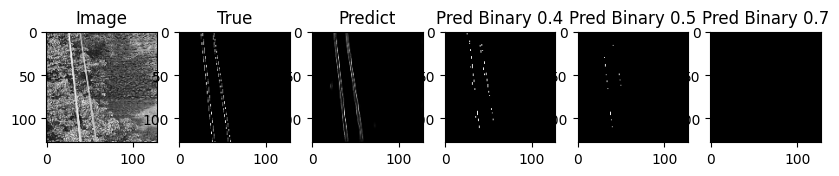

<Figure size 3000x700 with 0 Axes>

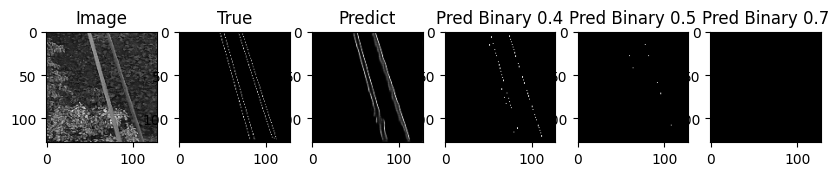

<Figure size 3000x700 with 0 Axes>

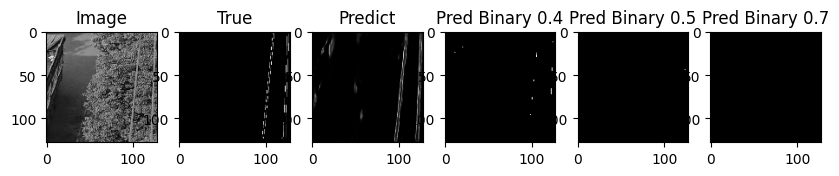

<Figure size 3000x700 with 0 Axes>

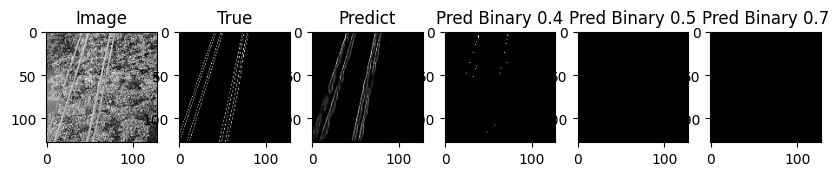

<Figure size 3000x700 with 0 Axes>

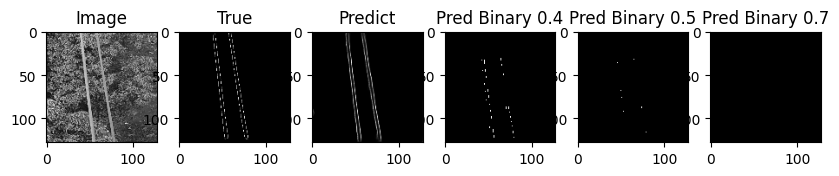

<Figure size 3000x700 with 0 Axes>

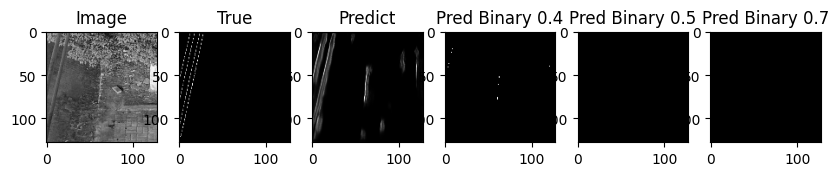

<Figure size 3000x700 with 0 Axes>

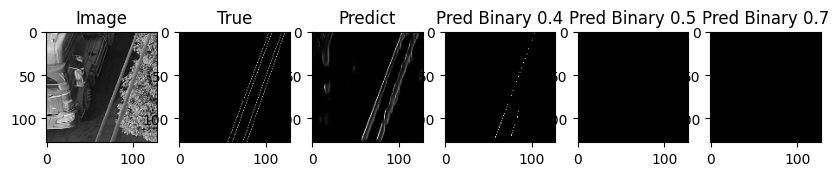

<Figure size 3000x700 with 0 Axes>

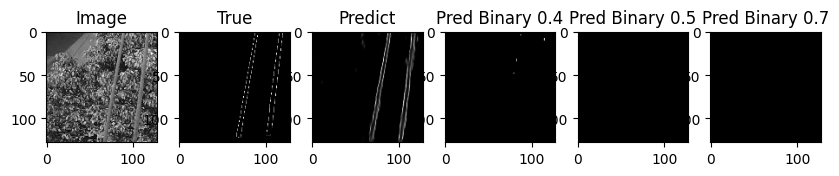

<Figure size 3000x700 with 0 Axes>

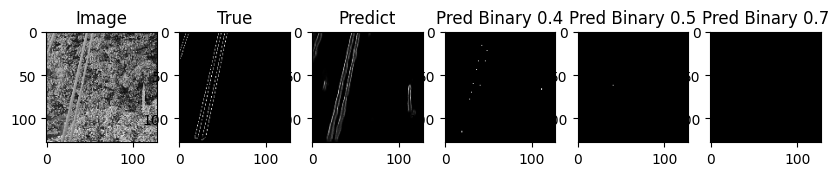

<Figure size 3000x700 with 0 Axes>

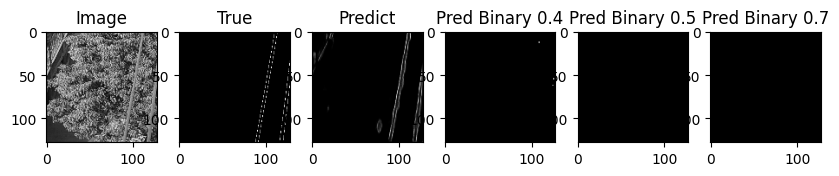

<Figure size 3000x700 with 0 Axes>

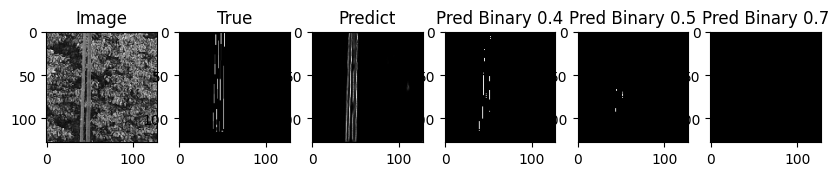

<Figure size 3000x700 with 0 Axes>

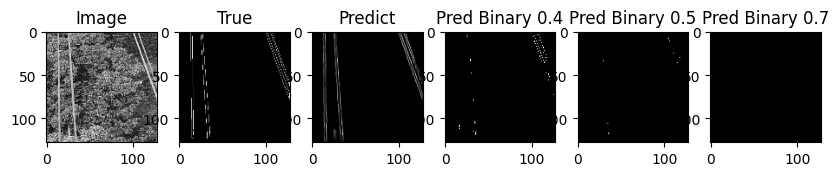

<Figure size 3000x700 with 0 Axes>

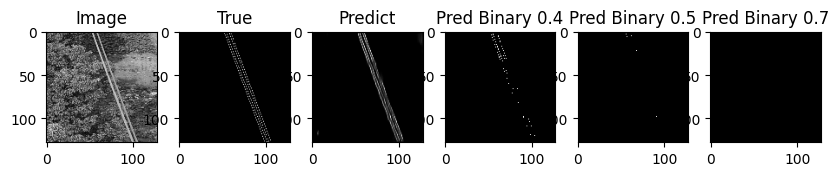

<Figure size 3000x700 with 0 Axes>

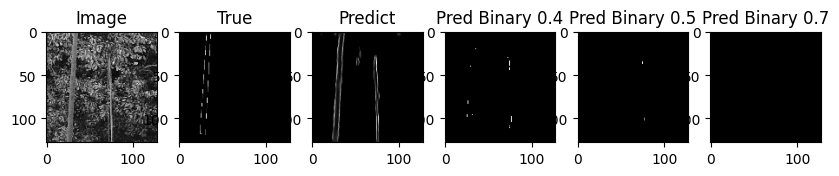

<Figure size 3000x700 with 0 Axes>

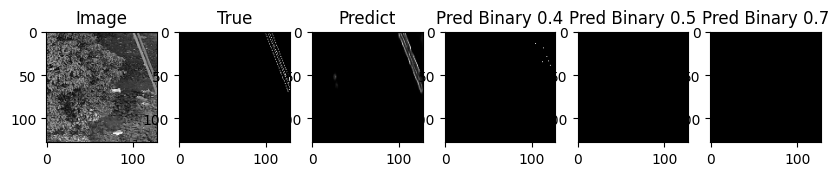

<Figure size 3000x700 with 0 Axes>

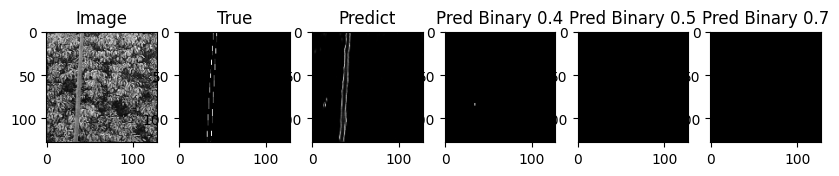

<Figure size 3000x700 with 0 Axes>

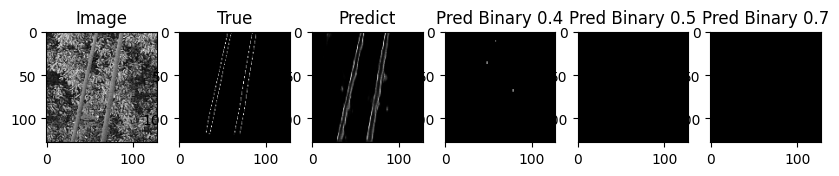

In [294]:
model = build_unet_model(is_out_gray=True)

model.load_weights("model/auc_metric_100/best_model.h5")

predict_n_plot(model, X_train, y_train)

#### AUC 1000

--------------------------------------Model Params-----------------------------------------
Optimizer= <keras.optimizers.legacy.adam.Adam object at 0x29dba5400>
loss= binary_crossentropy
metrics= ['AUC']
-----------------------------------------Model Training---------------------------------------------
Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 2.3864 - auc: 0.4917
Epoch 1: val_loss improved from inf to 0.20856, saving model to model/auc_metric/best_model.h5
3/3 [==============================] - 8s 2s/step - loss: 2.3864 - auc: 0.4917 - val_loss: 0.2086 - val_auc: 0.3096 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.2862 - auc: 0.4337
Epoch 2: val_loss did not improve from 0.20856
3/3 [==============================] - 8s 3s/step - loss: 0.2862 - auc: 0.4337 - val_loss: 0.3696 - val_auc: 0.3107 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.3376 - auc: 0.3297
Epoch 3: val_loss did not im

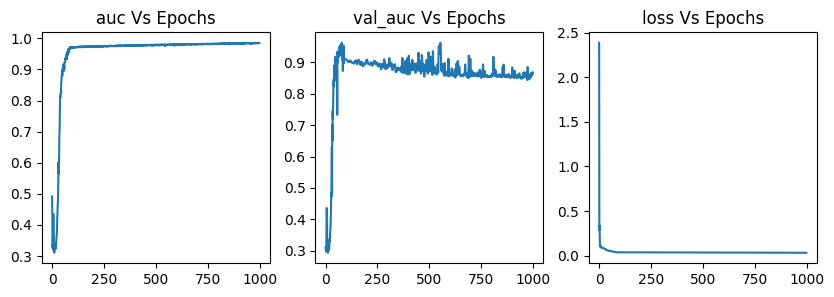

----------------------------------------Model Test Scores--------------------------------------------
1/1 [==============================] - 0s 202ms/step - loss: 0.0784 - auc: 0.8675
[0.07844657450914383, 0.8675044775009155]
---------------------------------Model Predictions : Test dataset ---------------------------------------
1/1 [==============================] - 0s 347ms/step


<Figure size 3000x700 with 0 Axes>

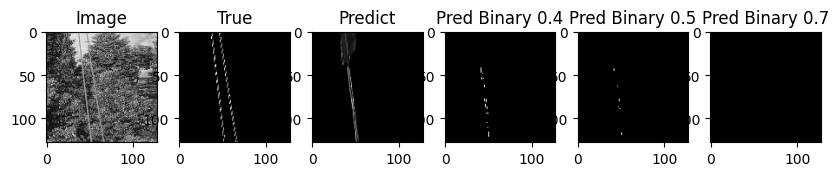

<Figure size 3000x700 with 0 Axes>

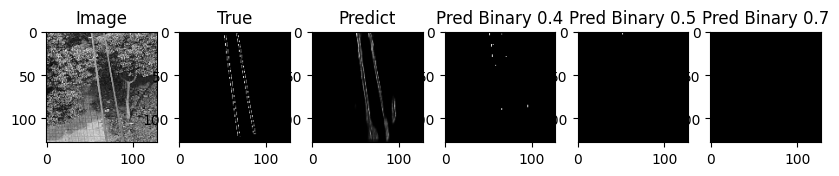

<Figure size 3000x700 with 0 Axes>

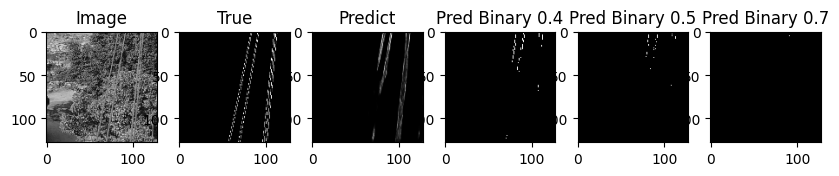

(<keras.engine.functional.Functional at 0x2c6ddab80>,
 <keras.callbacks.History at 0x2c6e59df0>)

In [15]:
epochs = 1000

callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/auc_metric/best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

train_unet_model(X_train, y_train, (X_test, y_test), epochs=epochs, metrics=['AUC'], callbacks=callbacks)

##### Train dataset

--------------------------------------Model Params-----------------------------------------
Optimizer= <keras.optimizers.legacy.adam.Adam object at 0x29da04bb0>
loss= binary_crossentropy
metrics= ['AUC']
1/1 [==============================] - 2s 2s/step - loss: 0.0334 - auc: 0.9809
[0.03337932378053665, 0.9809333682060242]
1/1 [==============================] - 2s 2s/step


<Figure size 3000x700 with 0 Axes>

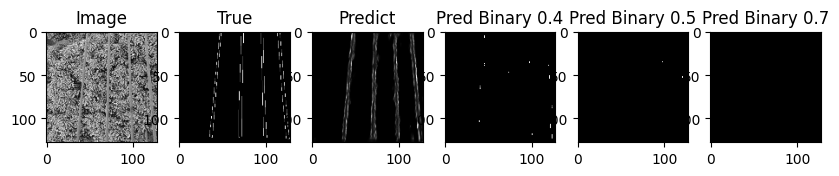

<Figure size 3000x700 with 0 Axes>

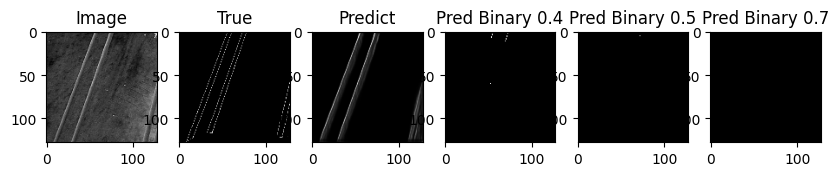

<Figure size 3000x700 with 0 Axes>

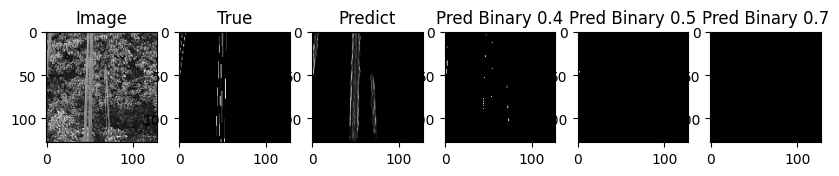

<Figure size 3000x700 with 0 Axes>

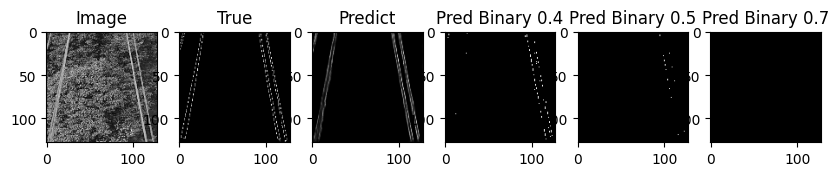

<Figure size 3000x700 with 0 Axes>

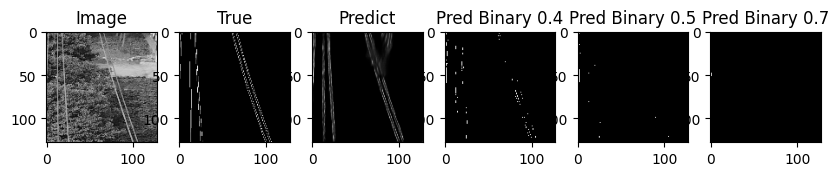

<Figure size 3000x700 with 0 Axes>

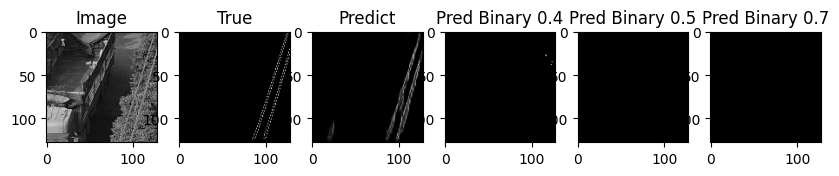

<Figure size 3000x700 with 0 Axes>

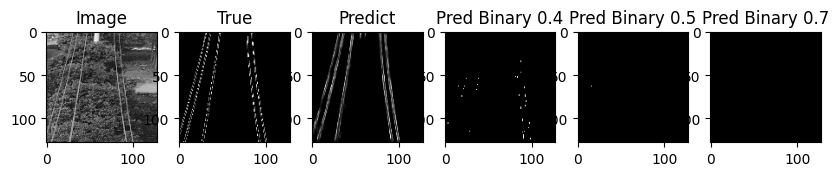

<Figure size 3000x700 with 0 Axes>

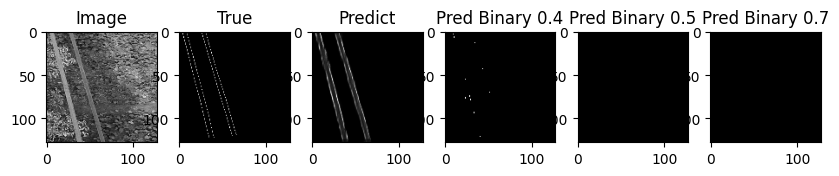

<Figure size 3000x700 with 0 Axes>

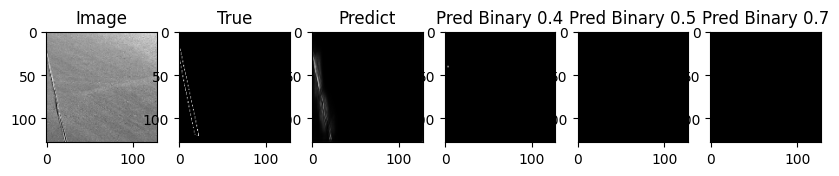

<Figure size 3000x700 with 0 Axes>

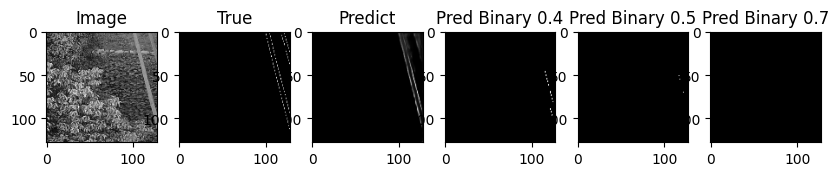

<Figure size 3000x700 with 0 Axes>

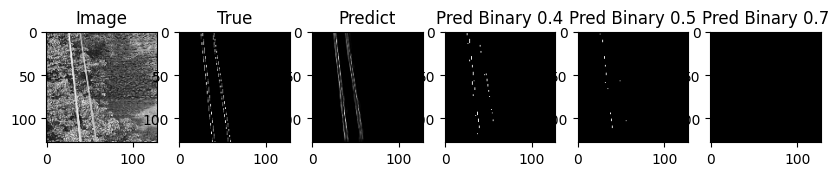

<Figure size 3000x700 with 0 Axes>

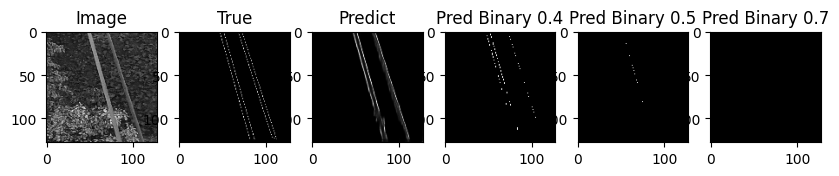

<Figure size 3000x700 with 0 Axes>

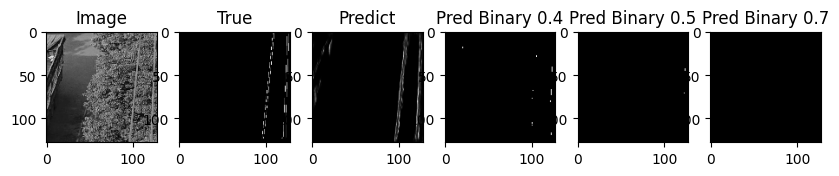

<Figure size 3000x700 with 0 Axes>

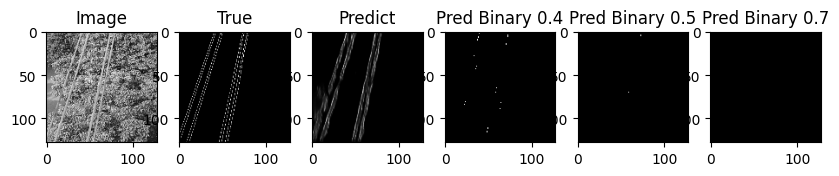

<Figure size 3000x700 with 0 Axes>

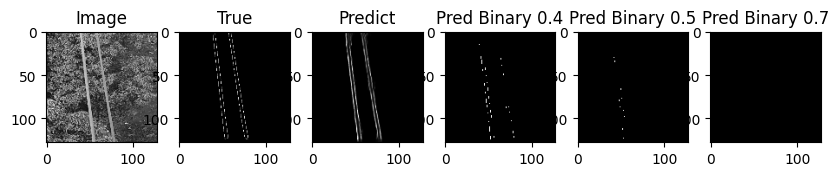

<Figure size 3000x700 with 0 Axes>

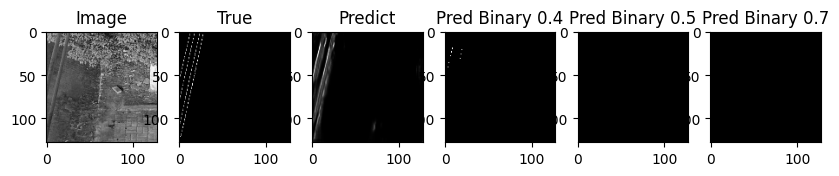

<Figure size 3000x700 with 0 Axes>

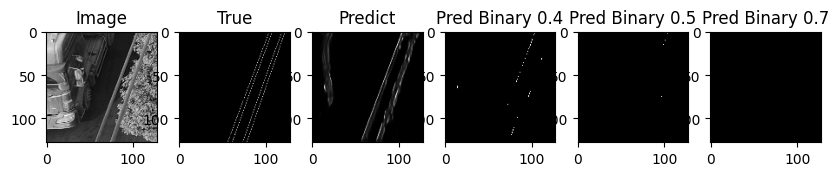

<Figure size 3000x700 with 0 Axes>

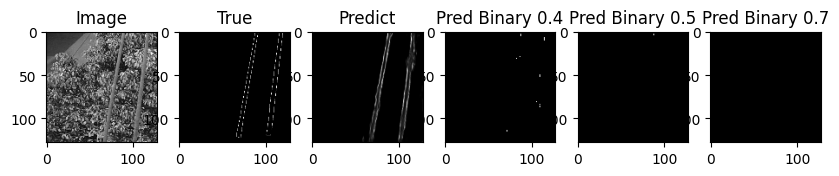

<Figure size 3000x700 with 0 Axes>

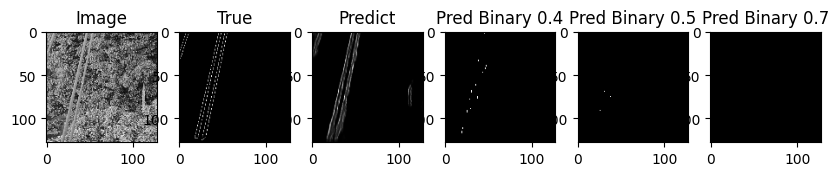

<Figure size 3000x700 with 0 Axes>

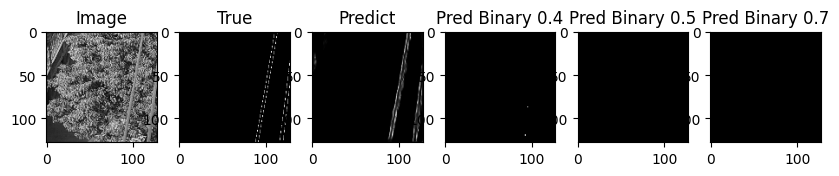

<Figure size 3000x700 with 0 Axes>

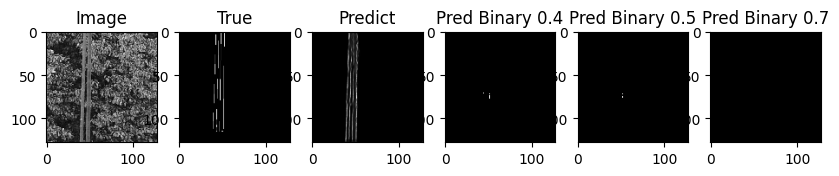

<Figure size 3000x700 with 0 Axes>

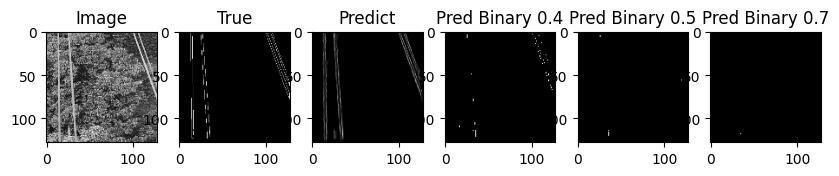

<Figure size 3000x700 with 0 Axes>

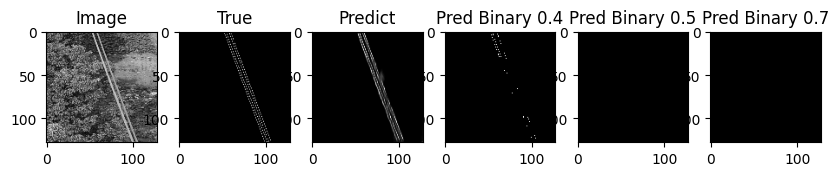

<Figure size 3000x700 with 0 Axes>

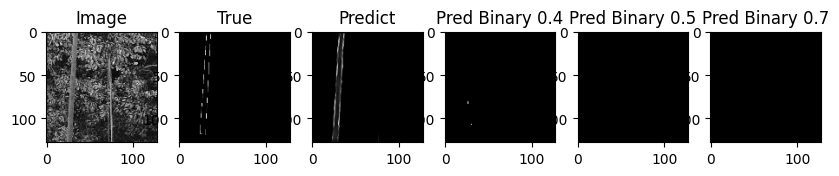

<Figure size 3000x700 with 0 Axes>

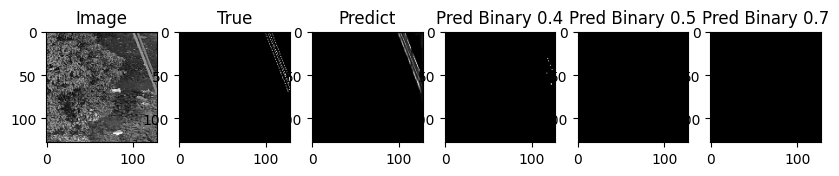

<Figure size 3000x700 with 0 Axes>

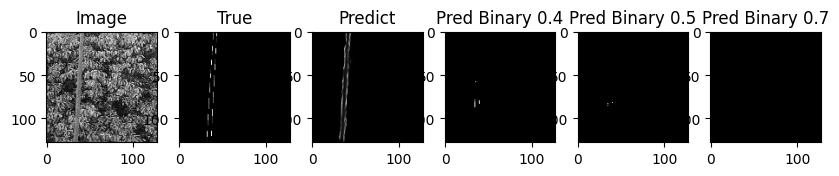

<Figure size 3000x700 with 0 Axes>

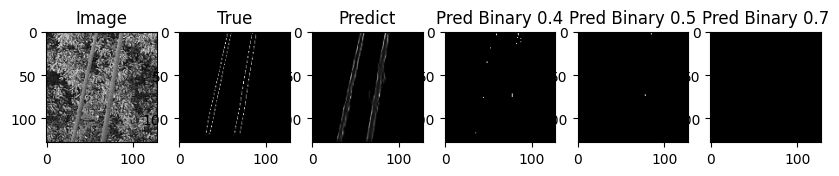

In [19]:
model = build_unet_model(is_out_gray=True, metrics=['AUC'])

model.load_weights("model/auc_metric/best_model.h5")

predict_n_plot(model, X_train, y_train)

#### Thresholds 0.4,0.5,0.7
Integrated with above experiments